High-performance and parallel computing for AI - Practical 6: Stochastic behaviour of rounding errors and stochastic rounding
=============================================================================================================================

IMPORTANT
=========

For these practicals we will be using a different `conda environment`. When opening a notebook or a terminal make sure you are using the **CuPy Kernel**!!!

Question 1 - One last dot product
---------------------------------

Let $a,b\in\mathbb{R}^n$ be defined by either of the following:

* Option 1 - The entries of $a,b$ are i.i.d. uniform random variables in $[0,1]$.
* Option 2 - $a_i = \alpha$, $b_i=\beta$ for all $i$ where $\alpha,\beta$ are independent uniform random variables in $[0,1]$ (i.e., $a,b$ are still random, but have constant entries).

Using fp16 half-precision and round-to-nearest (the default in `chopping`), compute the dot product $a\cdot b$ and its relative rounding error for both options above. Since the vectors are random, take the maximum error across $M=50$ realisations of the inputs. Plot the relative rounding error as a function of $n$ for $n=2^i$, $i=8,\cdots,14$ in loglog scale.

Repeat the experiment using stochastic rounding. How do the errors in round-to-nearest and stochastic rounding grow as a function of $n$?

**Hint:** To activate stochastic rounding, create and use an option with stochastic rounding enabled:
```python
    op = Option(True)
    op.set_format('h') # this is as usual
    op.set_round(5) # 5 for stochastic rounding, 1 for round-to-nearest
```

**Hint:** Here is a useful code portion:

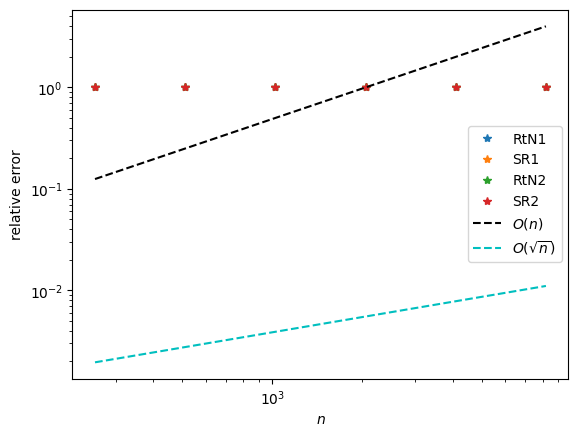

In [1]:
import numpy as np
from chopping import *
import matplotlib.pyplot as plt

op = Option(True)
op.set_format('h')
op.set_round(1)

u = op.get_floating_point_parameters()["u"]

sr = Option(True)
sr.set_format('h')
sr.set_round(5)

def dot(a,b,opt):
    return (LPV(a, opt).T()@LPV(b, opt)).array()[0]

def one_test(n):

    # CHANGE THIS FUNCTION BY USING THE dot FUNCTION ABOVE

    # option 1
    ex1 = 1
    rtn1 = 0
    sr1 = 0

    #option 2
    ex2 = 1
    rtn2 = 0
    sr2 = 0
    
    return [abs(ex1-rtn1)/abs(ex1), abs(ex1-sr1)/abs(ex1), abs(ex2-rtn2)/abs(ex2), abs(ex2-sr2)/abs(ex2)]

def test(n,M):
    return np.max(np.array([one_test(n) for i in range(M)]),axis=0)

NN = 2**np.arange(8,14)
M = 50

errs = np.array([test(n,M) for n in NN])


labels = ["RtN1", "SR1", "RtN2", "SR2"]
for i in range(4):
    plt.loglog(NN, errs[:,i], '*', label=labels[i])

plt.loglog(NN, u*NN, 'k--', label="$O(n)$")
plt.loglog(NN, u*np.sqrt(NN)/4, 'c--', label=r"$O(\sqrt{n})$")

plt.legend()
plt.xlabel("$n$")
plt.ylabel("relative error")
plt.show()

Question 2
----------

Using fp16 and round-to-nearest, evaluate the truncated harmonic sum

$$ \sum_{n=1}^N \frac{1}{n} $$

for $N=2^{6}$, $N=2^{10}$, $N=2^{14}$. What is the result? What happens if the same value is computed using double precision? What is the exact value of the sum for $N\rightarrow \infty$?

Repeat the above with bf16 and round-to-nearest. What changed? Why?

Repeat using fp16 and stochastic rounding. What changed? Why?

Can you approximately predict at which value of $N$ will stagnation occur for round-to-neareset and fp16?

Hint for the last question: 1) Approximate the sum with $\log(N) + \gamma + \frac{1}{2N}$ where $\gamma$ is the Euler-Mascheroni constant. 2) Under which condition stagnation occurs? You will need to know the roundoff unit of fp16 which is $2^{-11}$. 3) Use `scipy.optimize.root_scalar` to find an approximate $N$ at which stagnation occurs.

Question 3 - Stochastic rounding and gradient descent
-----------------------------------------------------

**Important:** For this exercise you can modify your solution to Question 3 of Practical 5.

Implement the gradient descent method in double precision for minimizing the 2D Rosenbrock function:

$$ f(x,y) = (a-x)^2 + b(y-x^2)^2 $$

where $a=\pi-3$, $b=100$. This function has a unique global minimum at the point $(a, a^2)$. Set the learning rate to $10^{-3}$, the initial condition to zero and the maximum number of iterations to $2 \times 10^4$.

1- Copy and clean up your code from Question 3 of Practical 5 to only keep the pure bfloat16 reduced-precision scheme.

2- Change the `chopping` `Option` rounding mode to stochastic rounding with `op.set_round(5)` and run the code again.

In order to monitor the convergence behaviour of the above, compute the Euclidean norm of the gradient at the current iterate every $100$ iterations. Run both implementations and compare their gradient norms. Can you explain this convergence behaviour based on what we have learnt in the lectures?

Finally, re-run the experiment by setting $a=1/8$. What do you observe? Why do you think this happens?

**Some explanation:** The stochastic rounding evaluation of the gradient here does not have zero-mean error since the gradient is a nonlinear function. However, its bias will be of order $O(u^2)$ (you can try and prove this if you have time, simply Taylor-expand the gradient with respect to the rounding errors and take the expectation). Therefore, gradient descent will have the gradient norm (not its square) converge like $O(1/\sqrt{T})$ until it reaches the RtN bias $O(u)$. For RtN it will stop, while for stochastic rounding it will behave like stochastic gradient descent and will keep converging until it reaches the SR bias $O(u^2)$ when it will stop converging.